# Проектная работа по приоритезации гипотез с последующим анализом результатов А/В- теста

В нашем распоряжении есть три датасета. В первом датасете представлена информация с девятью гипотезами по увеличению выручки интернет-магазина. Во втором и третьем датасетах находится информация о результатах проведенного А/В-теста. 

Цели данной работы:
1. Применить фреймворки ICE и RICE для приоритезации гипотез
2. Проанализировать А/В-тест
3. Принять решение по результатам теста 

## Приоритезация гипотез

`Импортируем нужные библиотеки и сохраним датасет в переменную hypotheses.`

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
hypotheses = pd.read_csv('/datasets/hypothesis.csv')

`Применим фреймворк ICE для приоритезации гипотез и отсортируем их по убыванию приоритета.`

In [3]:
hypotheses['ICE'] = (hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Efforts']).round(2)

In [4]:
hypotheses[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


`Наиболее перпспективными являются гипотезы 8,0,7.`

`Теперь посчитаем RICE для гипотез и отсортируем по убыванию приоритета.`

In [5]:
hypotheses['RICE'] = hypotheses['Reach'] * hypotheses['Impact'] * hypotheses['Confidence'] / hypotheses['Efforts']

In [6]:
hypotheses.sort_values(by='RICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,Добавить форму подписки на все основные страни...,10,7,8,5,11.20,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6,13.33,40.0
6,Показать на главной странице баннеры с актуаль...,5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сок...",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1,1.00,3.0


`Применение фреймворка RICE меняет приоритет гипотез: самыми перспективными становятся 7,2,0 и 6.`

## Анализ А/В-теста

`Сохраним датасеты в переменные orders и visitors.`

In [7]:
orders = pd.read_csv('/datasets/orders.csv')

In [8]:
visitors = pd.read_csv('/datasets/visitors.csv')

`Преобразуем тип данных в столбцах date в datetime обоих датасетов.`

In [9]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

### Кумулятивная выручка по группам

`В переменную date_group сохраним массив уникальных пар значений дат и групп теста.`

In [10]:
date_group = orders[['date','group']].drop_duplicates()

`В переменную orders_cumulative сохраним агрегированные кумулятивные данные о заказах по дням.`

In [11]:
orders_cumulative = date_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                     orders['group'] == x['group'])]
                                     .agg({'date':'max',
                                           'group':'max',
                                           'transactionId':'nunique',
                                           'visitorId':'nunique',
                                           'revenue':'sum'}), axis=1).sort_values(by=['date'])

`Сохраним в переменные срезы, хранящие данные о дате и выручке по группе А и В.`

In [12]:
orders_cumulative_revenue_a = orders_cumulative[orders_cumulative['group']=='A'][['date','revenue','transactionId']]

In [13]:
orders_cumulative_revenue_b = orders_cumulative[orders_cumulative['group']=='B'][['date','revenue','transactionId']]

`Построим график кумулятивной выручки по группам.`

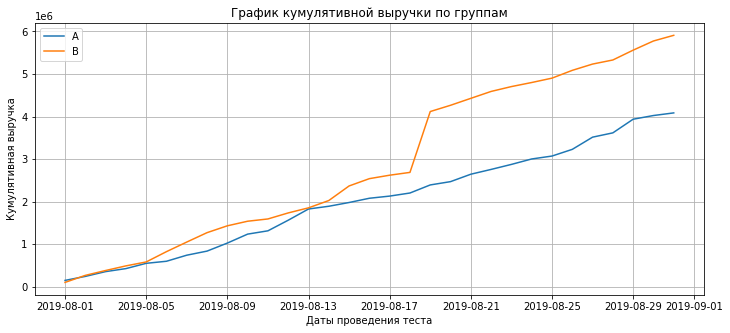

In [14]:
plt.figure(figsize=(12,5))
plt.plot(orders_cumulative_revenue_a['date'],orders_cumulative_revenue_a['revenue'], label='A')
plt.plot(orders_cumulative_revenue_b['date'],orders_cumulative_revenue_b['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.grid(True)
plt.xlabel('Даты проведения теста')
plt.ylabel('Кумулятивная выручка')
plt.show()

`Выручка в обеих группах равномерно увеличивается. В группе В есть резкие скачки, что может говорить о наличии выбросов. `

### Кумулятивный средний чек по группам

`Построим график кумулятивного среднего чека по группам.`

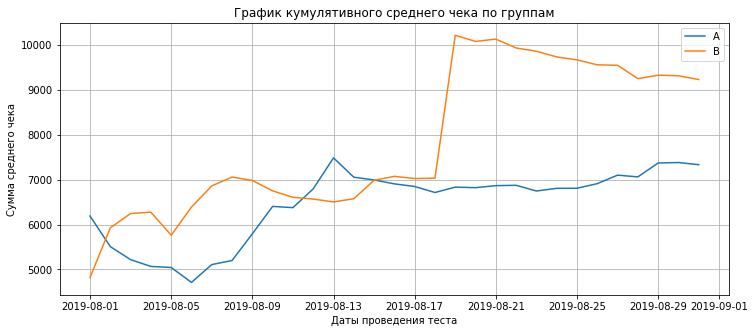

In [15]:
plt.figure(figsize=(12,5))
plt.plot(orders_cumulative_revenue_a['date'],orders_cumulative_revenue_a['revenue']/orders_cumulative_revenue_a['transactionId'], label='A')
plt.plot(orders_cumulative_revenue_b['date'],orders_cumulative_revenue_b['revenue']/orders_cumulative_revenue_b['transactionId'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по группам')
plt.grid(True)
plt.ylabel('Сумма среднего чека')
plt.xlabel('Даты проведения теста')
plt.show()

`К середине теста средний чек группы А начал устанавливаться. В группе В на середине теста произошел резкий скачок, что может говорить об аномалиях в данных.`

### Относительное изменение кумулятивного среднего чека группы B к группе A

`Объединим данные о выручке по группам в один датасет и сохраним все в переменную merge_cum_revenue_ab.`

In [16]:
merge_cam_revenue_ab = orders_cumulative_revenue_a.merge(orders_cumulative_revenue_b,
                                                         how='left',
                                                         left_on='date',
                                                         right_on='date',
                                                         suffixes=['A', 'B'])

`Строим график.`

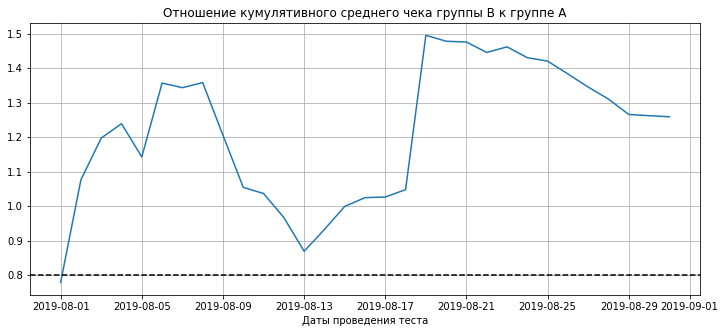

In [17]:
plt.figure(figsize=(12,5))
plt.plot(merge_cam_revenue_ab['date'],(merge_cam_revenue_ab['revenueB']/merge_cam_revenue_ab['transactionIdB']) / (merge_cam_revenue_ab['revenueA']/merge_cam_revenue_ab['transactionIdA']-1))
plt.title('Отношение кумулятивного среднего чека группы B к группе A')
plt.axhline(y=0.8, color='black', linestyle='--')
plt.grid(True)
plt.xlabel('Даты проведения теста')
plt.show()

`На графике видны резкие скачки, что может говорить об аномалиях в данных.`

### Кумулятивная конверсия по группам

`В переменную visits_cumulative сохраним данные о кумулятивных посещениях интернет-магазина.`

In [18]:
visits_cumulative = date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                       visitors['group'] ==x['group'])]
                                     .agg({'date':'max',
                                           'group':'max',
                                           'visitors':'nunique'}),axis=1).sort_values(by='date')

`Для рассчета конверсии объединим visits_cumulative и orders_cumulative.`

In [19]:
cumulative = visits_cumulative.merge(orders_cumulative, how='left')

In [20]:
cumulative.columns = ['date', 'group', 'visitors', 'orders', 'buyers', 'revenue']

`Считаем конверсию.`

In [21]:
cumulative['conversion'] = cumulative['orders'] / cumulative['visitors']

`Отделим данные по группам А и В.`

In [22]:
cumulative_a = cumulative[cumulative['group']=='A']

In [23]:
cumulative_b = cumulative[cumulative['group']=='B']

`Строим график кумулятивной конверсии по группам.`

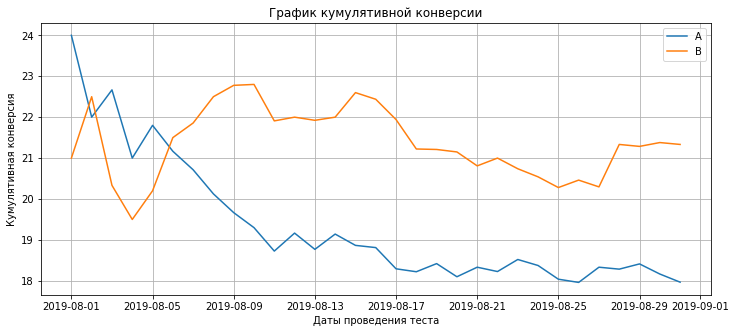

In [24]:
plt.figure(figsize=(12,5))
plt.plot(cumulative_a['date'], cumulative_a['conversion'], label='A')
plt.plot(cumulative_b['date'], cumulative_b['conversion'], label='B')
plt.legend()
plt.title('График кумулятивной конверсии')
plt.grid(True)
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Даты проведения теста')
plt.show()

`На графике видны скачки как в начале проведения теста, так и спустя некоторое время. Конверсия группы В уменьшается, а у группы А наблюдатеся рост.`

### Относительное изменение кумулятивной конверсии группы B к группе A

`Объединим данные по группам и построим график.`

In [25]:
merge_conversion_ab = cumulative_a[['date', 'conversion']].merge(cumulative_b[['date', 'conversion']],
                                                                 how='left',
                                                                 left_on ='date', 
                                                                 right_on='date',
                                                                suffixes=['A', 'B'])

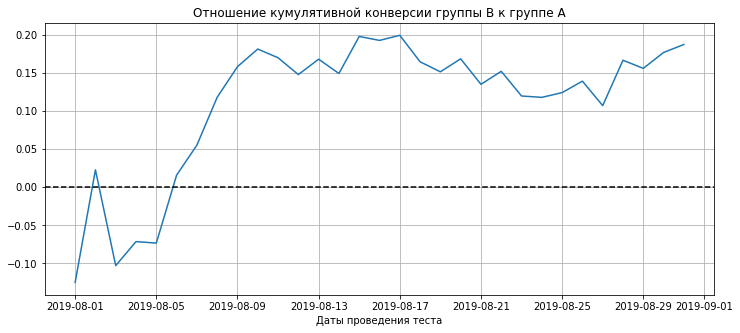

In [26]:
plt.figure(figsize=(12,5))
plt.plot(merge_conversion_ab['date'], 
         merge_conversion_ab['conversionB']/merge_conversion_ab['conversionA']-1)
plt.title('Отношение кумулятивной конверсии группы В к группе А')
plt.grid(True)
plt.xlabel('Даты проведения теста')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

`Виден резкий рост конверсии в начале проведения теста и ее последующий рост в дальнейшем.`

### Анализ выбросов

#### Количество заказов по пользователям

`Подсчитаем количество уникальных заказов по пользователям и сохраним эти данные в переменную orders_by_users.`

In [27]:
orders_by_users = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

In [28]:
x = pd.Series(range(0,len(orders_by_users))) #список с количеством пользователей для построения диаграммы

`Построим точечную диаграмму числа заказов на одного пользователя.`

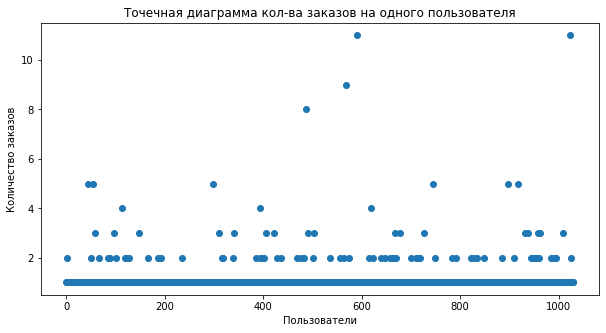

In [29]:
plt.figure(figsize=(10,5))
plt.scatter(x, orders_by_users['transactionId'])
plt.title('Точечная диаграмма кол-ва заказов на одного пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

`Основная масса заказов приходится на 1-2, также много пользователей, совершивших 3 заказа. Есть пользователи, совершившие больше 6 заказов.`

`Посчитаем 95 и 99 перцентили для количества заказов на одного пользователя.`

In [30]:
np.percentile(orders_by_users['transactionId'], [95,99])

array([2., 4.])

`Из рассчетов выше следует, что не более 5% пользователей совершили более 2-х заказов и не более 1% пользователей совершили более 4-х заказов. Будем считать, что аномальными являются те пользователи, которые совершили более 3-х заказов.`

#### Стоимость заказов

In [31]:
y = pd.Series(range(0,len(orders['revenue']))) #список кол-ва заказов для построения точечной диаграммы

`Построим диаграмму стоимости заказов.`

In [32]:
orders['revenue'].median()

2978.0

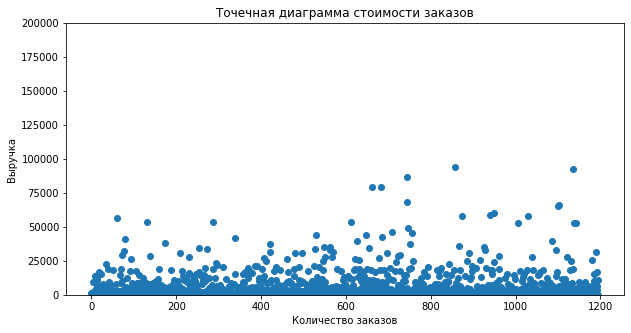

In [33]:
plt.figure(figsize=(10,5))
plt.scatter(y, orders['revenue'])
plt.title('Точечная диаграмма стоимости заказов')
plt.ticklabel_format(style='plain')
plt.xlabel('Количество заказов')
plt.ylabel('Выручка')
plt.ylim([0,200000])
plt.show()

`Диаграмма показывает, что основная масса заказов приходится на сумму до 25 тысяч. Есть несколько выбивающихся заказов.`

`Для точного выявления аномалий определим 95-й и 99-й перцентили стоимости заказов.`

In [34]:
np.percentile(orders['revenue'], [95,99])

array([28000. , 58233.2])

`Не более 5% заказов дороже 28000 рублей и не более 1% заказов дороже 58233 рублей. Будем считать, что заказы на сумму более 28000 рублей являются аномальными.`

### Расчет статистической значимости

#### Статистическая значимость различий конверсии между группами

`В переменные orders_group_a и orders_group_b сохраним данные по совершенным заказам для группы А и В. Проверим, есть ли пользователи, которые находятся в группе А и В одновременно. Если такие пользователи существуют, то удалим их.`

In [35]:
orders_group_a = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

In [36]:
orders_group_b = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})

In [37]:
a = set(orders_group_a['visitorId']) #создаем множество

In [38]:
b = set(orders_group_b['visitorId']) #создаем множество

In [39]:
c = list(a & b) #находим пересечения множества а и множества b

In [40]:
orders_group_a = orders_group_a[np.logical_not(orders_group_a['visitorId'].isin(c))] 
#пересохраняем в переменную данные без пересекающихся пользователей

In [41]:
orders_group_b = orders_group_b[np.logical_not(orders_group_b['visitorId'].isin(c))] 
#пересохраняем в переменную данные без пересекающихся пользователей

`Подготовим выборки к проверке критерием Манна-Уитни. Для этого в переменне sample_a и sample_b сохраним список со значениями заказов. Пользователи, не совершившие заказов будут обозначаться 0.`

In [42]:
sample_a = pd.concat([orders_group_a['transactionId'], pd.Series(0, index=np.arange((visitors[visitors['group']=='A']['visitors']).sum() - len(orders_group_a['transactionId'])))], axis=0)

In [43]:
sample_b = pd.concat([orders_group_b['transactionId'], pd.Series(0, index=np.arange((visitors[visitors['group']=='B']['visitors']).sum() - len(orders_group_b['transactionId'])))], axis=0)

`Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой. Также сформулируем нулевую и альтернативную гипотезы:`

`Нулевая гипотеза: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.`

In [44]:
"{0:.3f}".format(stats.mannwhitneyu(sample_a,sample_b)[1])

'0.011'

`p-value меньше 0,05, значит нулевую гипотезу можно отвергнуть и принять альтернативную, которая утверждает, что существуют различия в конверсии между группами.`

`Посмотрим на относительный прирост конверсии группы В.`

In [45]:
'{0:.3f}'.format(sample_b.mean() / sample_a.mean()-1)

'0.160'

`Прирост конверсии группы В составляет 16%.`

#### Cтатистическая значимость различий в среднем чеке заказа между группами

`Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой. Также сформулируем нулевую и альтернативную гипотезы:`

`Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная: различия в среднем чеке между группами есть.`

In [46]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1])

'0.729'

`p-value значительно больше 0,05, значит нет причин отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке.`

`Посмотрим на относительные различия в среднем чеке между группами.`

In [47]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean() / orders[orders['group']=='A']['revenue'].mean()-1)

'0.259'

`Прирост среднего чека группы В составляет 25,9%.`

### Расчет статистической значимости по данным без аномальных значений

`Аномальными являются те пользователи, которые совершили более 3-х заказов, а также заказы на сумму более 28000 рублей. Удалим аномальные значения и посмотрим, повлияет ли это на результаты расчета статистической значимости.` 

`В переменные orders_clean и revenue_clean сохраним данные без аномалий.`

In [48]:
orders_clean = pd.concat([orders_group_a[orders_group_a['transactionId'] > 3]['visitorId'],orders_group_b[orders_group_b['transactionId'] > 3]['visitorId']], axis=0)

In [49]:
revenue_clean = orders[orders['revenue'] >28000]['visitorId']

In [50]:
orders_revenue_clean = pd.concat([orders_clean,revenue_clean],axis=0).drop_duplicates()

`В переменные orders_clean_a и orders_clean_b сохраним выборки с количеством заказов без аномалий.`

In [51]:
orders_clean_a = pd.concat([orders_group_a[np.logical_not(orders_group_a['visitorId'].isin(orders_clean))]['transactionId'],
           pd.Series(0, index= np.arange((visitors[visitors['group']=='A']['visitors']).sum() - len(orders_group_a['transactionId'])))], axis=0)

In [52]:
orders_clean_b = pd.concat([orders_group_b[np.logical_not(orders_group_b['visitorId'].isin(orders_clean))]['transactionId'],
           pd.Series(0, index= np.arange((visitors[visitors['group']=='B']['visitors']).sum() - len(orders_group_b['transactionId'])))], axis=0)

#### Статистическая значимость различий в конверсии между группами

`Применим критерий Манна-Уитни к полученным выборкам и отформатируем p-value, округлив его до трёх знаков после запятой. Также сформулируем нулевую и альтернативную гипотезы:`

`Нулевая гипотеза: различий в конверсии между группами нет. Альтернативная: различия в конверсии между группами есть.`

In [53]:
'{0:.3f}'.format(stats.mannwhitneyu(orders_clean_a, orders_clean_b)[1])

'0.011'

`Результаты по конверсии не изменились без аномальных значений в выборке. p-value меньше 0,05. Это означает, что нулевую гипотезу об отсутствии различий в конверсии можно отвергнуть и принять альтернативную.`

`Посмотрим на относительный прирост конверсии группы В.`

In [54]:
'{0:.3f}'.format(orders_clean_b.mean() / orders_clean_a.mean()-1)

'0.160'

`Прирост конверсии группы В не изменился: все те же 16%.`

#### Cтатистическая значимость различий в среднем чеке заказа между группами

`Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой. Также сформулируем нулевую и альтернативную гипотезы:`

`Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная: различия в среднем чеке между группами есть.`

In [55]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', 
                                                          np.logical_not(orders['visitorId'].isin(orders_clean)))]['revenue'],
                                    orders[np.logical_and(orders['group']=='B',
                                                          np.logical_not(orders['visitorId'].isin(orders_clean)))]['revenue'])[1])

'0.729'

`p-value значительно больше 0,05, значит нет причин отвергнуть нулевую гипотезу об отсутствии различий в среднем чеке.`

`Посмотрим на относительный прирост среднего чека группы B.`

In [56]:
'{0:.3f}'.format(orders[np.logical_and(orders['group']=='B',
                                       np.logical_not(orders['visitorId'].isin(orders_clean)))]['revenue'].mean()
                 / orders[np.logical_and(orders['group']=='A',
                                         np.logical_not(orders['visitorId'].isin(orders_clean)))]['revenue'].mean()-1)

'0.259'

`Прирост среднего чека группы В тоже не изменился: 25,9 % .`

### Результаты теста

1. Расчет статистической значимости показал, что разница между конверсиями есть.
2. Нет статистически значимого различия в среднем чеке.
3. Результаты проверки данных с аномальными значениями никак не отличаются от результатов проверки данных, очищенных от аномалий.
4. Наблюдается прирост среднего чека группы В.
5. Наблюдается относительный прирост конверсии группы В.
6. График отношения кумулятивной конверсии имеет много скачков, но при этом показывает рост конверсии группы В.
7. По графику отношения кумулятивного среднего чека нельзя сделать однозначных выводов, т.к. на нем наблюдаются скачки за все время проведения теста.

`Исходя из пунктов выше, можно остановить тест, признать его успешным и сделать вывод, что группа В лучше группы А.`